In [1]:

# !pip install -r requirements.txt


In [2]:
# Imports

import datasets
from datasets import Dataset
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
import sklearn
from sklearn.metrics import (
    accuracy_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
import torch
import evaluate
import pandas as pd

%env WANDB_DISABLED=true


env: WANDB_DISABLED=true


In [3]:
# Library Versions
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("PyTorch version:", torch.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Evaluate version:", evaluate.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)


Transformers version: 4.51.1
Datasets version: 3.5.0
PyTorch version: 2.1.0+cu118
scikit-learn version: 1.3.2
Evaluate version: 0.4.3
Pandas version: 2.2.3
NumPy version: 1.26.4


In [5]:
# Adjust to local file location
reviewsDF = pd.read_csv(
    "C:/Users/danie/Downloads/reviews_with_locations.csv.gz",
    compression='gzip',
    usecols=["text", "state", "region"]
)

# Preview the data
reviewsDF.head()

,text,state,region
0,"If you decide to eat here, just be aware it is...",PA,Northeast
1,This is the second time we tried turning point...,PA,Northeast
2,The place is cute and the staff was very frien...,PA,Northeast
3,We came on a Saturday morning after waiting a ...,PA,Northeast
4,"Mediocre at best. The decor is very nice, and ...",PA,Northeast


## Data Manipulation

In [6]:
max_per_region = 10000

# Used AI to help split into balanced dataset
balancedRegionDF = (
    reviewsDF.groupby("region", group_keys=False)
    .apply(
        lambda x: x.assign(region=x.name).sample(n=max_per_region, random_state=42)
        if len(x) > max_per_region else x.assign(region=x.name),
        include_groups=False
    )
    .reset_index(drop=True)
)



In [7]:
max_per_state = 5000

balancedStateDF = (
    reviewsDF.groupby("state", group_keys=False)
    .apply(
        lambda x: x.assign(state=x.name).sample(n=max_per_state, random_state=42)
        if len(x) > max_per_state else x.assign(state=x.name),
        include_groups=False
    )
    .reset_index(drop=True)
)



In [8]:
# Replace whitespace characters with a single space and remove trailing whitespace
balancedRegionDF["text"] = balancedRegionDF["text"].str.replace(r'\s+', ' ', regex=True).str.strip()
balancedStateDF["text"] = balancedStateDF["text"].str.replace(r'\s+', ' ', regex=True).str.strip()


print(balancedRegionDF.head())
print(balancedStateDF.head())

                                                text state   region
0  Went yesterday for a CMA appointment at 1230p....    IN  Midwest
1  What an experience! This beautiful new shop is...    IL  Midwest
2  The Pig is OK. I've come here for years becaus...    IN  Midwest
3  Nestled close to the intersection of 44 and S....    MO  Midwest
4  I'm loving what they've done with the place. N...    MO  Midwest
                                                text region state
0  Love this place. They have quality coffee and ...   West    AZ
1  We love this place! Toro loco is our go-to for...   West    AZ
2  I've been to three locations all together thro...   West    AZ
3  Since retirement, we've traveled much of the c...   West    AZ
4  Best bourbon / whiskey menu in town. During th...   West    AZ


In [9]:
# Check label counts
print(balancedRegionDF["region"].value_counts())
print(balancedStateDF["state"].value_counts())

region
Midwest      10000
Northeast    10000
South        10000
West         10000
Name: count, dtype: int64
state
AZ    5000
CA    5000
DE    5000
FL    5000
ID    5000
IL    5000
IN    5000
LA    5000
MO    5000
NJ    5000
NV    5000
PA    5000
TN    5000
Name: count, dtype: int64


## RoBERTa 4 Regions: Fine-tuning & Evaluation

We wanted to fine-tune and evaluate another transformer model to compare against BERT-base-uncased, which led us to chosing RoBERTa. The structure of the notebooks for the two transformers are nearly identical. First we tested 4 regions without prompting to compare against the BERT model we fine-tuned. 

In [10]:
# Mappings for labels to ids and id to labels
# Needed for BERT fine-tuning and evaluation, model expects numeric labels
labels = sorted(balancedRegionDF["region"].unique())

# Create mappings dynamically
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

# Map labels to numeric IDs
balancedRegionDF["label"] = balancedRegionDF["region"].map(label2id)

# Sanity Check
print(balancedRegionDF.head())

# Shuffle Data
balancedRegionDF = balancedRegionDF.sample(frac=1, random_state=42).reset_index(drop=True)

# Sanity Check
print(balancedRegionDF.head())



                                                text state   region  label
0  Went yesterday for a CMA appointment at 1230p....    IN  Midwest      0
1  What an experience! This beautiful new shop is...    IL  Midwest      0
2  The Pig is OK. I've come here for years becaus...    IN  Midwest      0
3  Nestled close to the intersection of 44 and S....    MO  Midwest      0
4  I'm loving what they've done with the place. N...    MO  Midwest      0
                                                text state     region  label
0  Mom's 80th birthday and we picked the Stone Ho...    NV       West      3
1  The only reason this place doesn't have 4.5 st...    PA  Northeast      1
2  A TRULY amazing meal and overall dining experi...    LA      South      2
3  I got a chance to stop in here for an early di...    IN    Midwest      0
4  A great brunch spot! Amazing sandwiches, at a ...    LA      South      2


In [11]:
%env WANDB_DISABLED=true
from transformers import logging


# Convert Pandas DF to Hugging Face Dataset
dataset = Dataset.from_pandas(balancedRegionDF[["text", "label"]])

# 80% train, 20% holdout
train_val_test = dataset.train_test_split(test_size=0.2, seed=42)

# Split 20% into 10% val and 10% test
val_test_split = train_val_test["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = train_val_test["train"]
eval_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]


# Load in RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)


# Tokenize and prepare datasets
train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set dataset format
columns = ["input_ids", "attention_mask", "label"]
train_dataset.set_format("torch", columns=columns)
eval_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)


# Load in RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Training configuration
training_args = TrainingArguments(
    output_dir="./results-roberta-base",
    eval_strategy="steps",            
    eval_steps=250,                    
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,               
    save_total_limit=1,
    logging_dir="./logs-roberta-base",
    logging_steps=250,
    fp16=torch.cuda.is_available(),
    report_to="none",                
)




# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

# Final eval
metrics = trainer.evaluate(test_dataset)
print(" Eval Output:", metrics)


# Save model and tokenizer locally
model.save_pretrained("./roberta-base-yelp-model")
tokenizer.save_pretrained("./roberta-base-yelp-model")


env: WANDB_DISABLED=true


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\danie\AppData\Local\Temp\ipykernel_7416\2995712059.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.372500,1.247239,0.428250,0.427811
500,1.199000,1.170800,0.432000,0.417915
750,1.166400,1.140767,0.443000,0.430155
1000,1.149300,1.128108,0.446750,0.439798
1250,1.124200,1.119030,0.453500,0.451252
1500,1.120300,1.148069,0.467250,0.464282
1750,1.115100,1.122899,0.472750,0.471713
2000,1.120200,1.100581,0.478500,0.474874
2250,1.069200,1.129323,0.481750,0.481643
2500,1.050500,1.128244,0.485000,0.476002


 Eval Output: {'eval_loss': 1.1501760482788086, 'eval_accuracy': 0.504, 'eval_f1': 0.5038136474030183, 'eval_runtime': 7.201, 'eval_samples_per_second': 555.475, 'eval_steps_per_second': 34.717, 'epoch': 5.0}


('./roberta-base-yelp-model\\tokenizer_config.json',
 './roberta-base-yelp-model\\special_tokens_map.json',
 './roberta-base-yelp-model\\vocab.json',
 './roberta-base-yelp-model\\merges.txt',
 './roberta-base-yelp-model\\added_tokens.json',
 './roberta-base-yelp-model\\tokenizer.json')

In [12]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print("\n Classification Report:\n")
print(classification_report(labels, preds, target_names=[id2label[i] for i in sorted(id2label.keys())]))

# Confusion matrix
print("\n Confusion Matrix:\n")
print(confusion_matrix(labels, preds))


 Classification Report:

              precision    recall  f1-score   support

     Midwest       0.50      0.47      0.48      1013
   Northeast       0.53      0.48      0.50      1004
       South       0.53      0.51      0.52      1012
        West       0.47      0.56      0.51       971

    accuracy                           0.50      4000
   macro avg       0.51      0.50      0.50      4000
weighted avg       0.51      0.50      0.50      4000


 Confusion Matrix:

[[477 156 168 212]
 [153 480 163 208]
 [161 133 516 202]
 [164 129 135 543]]


Compared to the BERT model, the RoBERTa model performs slightly worse overall. The weighted avg f1-score of 0.50 is slightly lower than the BERT model's 0.51 weighted avg f1-score. The RoBERTa and BERT models had very similar training times, which RoBERTa taking slightly longer. 

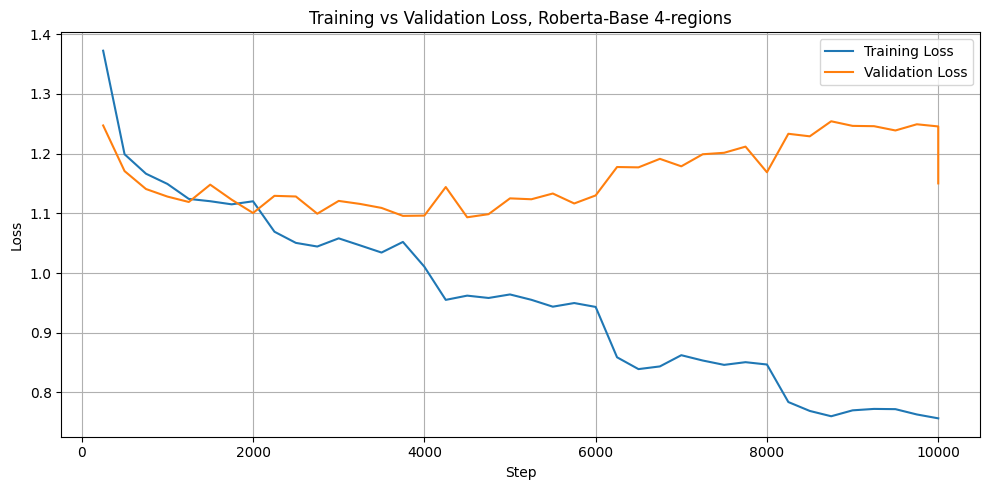

In [13]:
import matplotlib.pyplot as plt

# Get log history
logs = trainer.state.log_history

# Extract training and validation loss values
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
train_steps = [log["step"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss, Roberta-Base 4-regions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Validation curve does not increase to the same level as the BERT model during fine tuning, but there is still a slight increase over time. Training loss continues to decrease over time. 

## RoBERTa 4 Regions w/ Prompt: Fine-tuning & Evaluation

Following in the steps of the BERT notebook, we also tried hard prompting with RoBERTa to see if it would make a difference in performance. 

In [14]:
%env WANDB_DISABLED=true
from transformers import logging

# Add prompt
prompt = "Classify the region: "
balancedRegionDF["prompted_text"] = prompt + balancedRegionDF["text"]

# Convert Pandas DF to Hugging Face Dataset
dataset = Dataset.from_pandas(balancedRegionDF[["prompted_text", "label"]])

# 80% train, 20% holdout 
train_val_test = dataset.train_test_split(test_size=0.2, seed=42)

# Split 20% into 10% val and 10% test
val_test_split = train_val_test["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = train_val_test["train"]
eval_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]


# Load in RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["prompted_text"], padding="max_length", truncation=True, max_length=260)


# Tokenize and prepare datasets
train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set dataset format
columns = ["input_ids", "attention_mask", "label"]
train_dataset.set_format("torch", columns=columns)
eval_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)


# Load in RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Training configuration
training_args = TrainingArguments(
    output_dir="./results-roberta-base-prompted",
    eval_strategy="steps",            
    eval_steps=250,                    
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,               
    save_total_limit=1,
    logging_dir="./logs-roberta-base-prompted",
    logging_steps=250,
    fp16=torch.cuda.is_available(),
    report_to="none",                
)




# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

#  Final eval
metrics = trainer.evaluate(test_dataset)
print(" Eval Output:", metrics)


# Save model and tokenizer locally
model.save_pretrained("./roberta-base-yelp-model-prompted")
tokenizer.save_pretrained("./roberta-base-yelp-model-prompted")


env: WANDB_DISABLED=true


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\danie\AppData\Local\Temp\ipykernel_7416\3522872134.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
250,1.372700,1.240136,0.392500,0.377472
500,1.192400,1.175016,0.433000,0.432426
750,1.171900,1.162116,0.438500,0.432843
1000,1.164500,1.143376,0.448750,0.443172
1250,1.140900,1.150156,0.457750,0.456777
1500,1.122700,1.145946,0.456750,0.455961
1750,1.118100,1.139737,0.456000,0.454147
2000,1.122500,1.122339,0.462250,0.460981
2250,1.086900,1.135807,0.475500,0.474826
2500,1.058600,1.151630,0.477250,0.468040


 Eval Output: {'eval_loss': 1.1518261432647705, 'eval_accuracy': 0.50375, 'eval_f1': 0.5039857089536124, 'eval_runtime': 7.7336, 'eval_samples_per_second': 517.226, 'eval_steps_per_second': 32.327, 'epoch': 5.0}


('./roberta-base-yelp-model-prompted\\tokenizer_config.json',
 './roberta-base-yelp-model-prompted\\special_tokens_map.json',
 './roberta-base-yelp-model-prompted\\vocab.json',
 './roberta-base-yelp-model-prompted\\merges.txt',
 './roberta-base-yelp-model-prompted\\added_tokens.json',
 './roberta-base-yelp-model-prompted\\tokenizer.json')

In [15]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print("\n Classification Report:\n")
print(classification_report(labels, preds, target_names=[id2label[i] for i in sorted(id2label.keys())]))

# Confusion matrix
print("\n Confusion Matrix:\n")
print(confusion_matrix(labels, preds))


 Classification Report:

              precision    recall  f1-score   support

     Midwest       0.46      0.55      0.50      1013
   Northeast       0.48      0.54      0.50      1004
       South       0.59      0.44      0.51      1012
        West       0.53      0.48      0.51       971

    accuracy                           0.50      4000
   macro avg       0.51      0.50      0.50      4000
weighted avg       0.51      0.50      0.50      4000


 Confusion Matrix:

[[559 216 111 127]
 [228 539 102 135]
 [218 197 448 149]
 [223 182  97 469]]


There is no overall performance increase from prompting, which is same as BERT. F1-scores for all of the regions are slightly closer together compared to the model without prompting. 

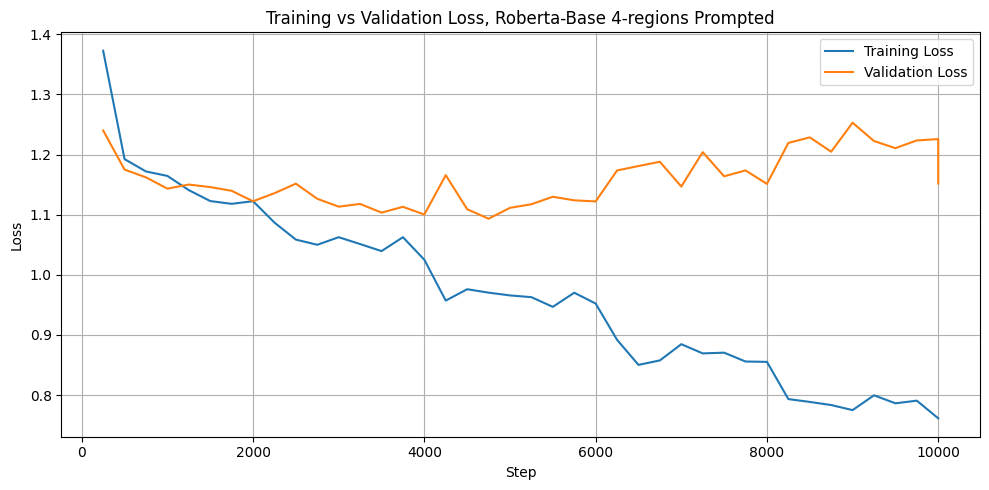

In [16]:
import matplotlib.pyplot as plt

# Get log history
logs = trainer.state.log_history

# Extract training and validation loss values
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
train_steps = [log["step"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss, Roberta-Base 4-regions Prompted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training and validation curves from with and without hard prompting look almost identical. 

## RoBERTa 13 States: Fine-tuning & Evaluation

Lastly, we transitioned away from regions and towards using the 13 states as labels.

In [17]:
# Mappings for labels to ids and id to labels
# Needed for BERT fine-tuning and evaluation, model expects numeric labels
labels = sorted(balancedStateDF["state"].unique())

# Create mappings dynamically
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

# Map labels to numeric IDs
balancedStateDF["label"] = balancedStateDF["state"].map(label2id)

# Sanity Check
print(balancedStateDF.head())

# Shuffle Data
balancedStateDF = balancedStateDF.sample(frac=1, random_state=42).reset_index(drop=True)

# Sanity Check
print(balancedStateDF.head())



                                                text region state  label
0  Love this place. They have quality coffee and ...   West    AZ      0
1  We love this place! Toro loco is our go-to for...   West    AZ      0
2  I've been to three locations all together thro...   West    AZ      0
3  Since retirement, we've traveled much of the c...   West    AZ      0
4  Best bourbon / whiskey menu in town. During th...   West    AZ      0
                                                text     region state  label
0  We went there tonight for dinner and drinks. T...    Midwest    IL      5
1  Trevor knows so much about all aspects of K9 f...       West    NV     10
2  Poor customer service! No one was answering wh...      South    FL      3
3  Came here yesterday to grab some dinner and dr...  Northeast    DE      2
4  Grace and Pats has made it's new home on East ...  Northeast    PA     11


In [18]:
print(label2id)
print(id2label)

{'AZ': 0, 'CA': 1, 'DE': 2, 'FL': 3, 'ID': 4, 'IL': 5, 'IN': 6, 'LA': 7, 'MO': 8, 'NJ': 9, 'NV': 10, 'PA': 11, 'TN': 12}
{0: 'AZ', 1: 'CA', 2: 'DE', 3: 'FL', 4: 'ID', 5: 'IL', 6: 'IN', 7: 'LA', 8: 'MO', 9: 'NJ', 10: 'NV', 11: 'PA', 12: 'TN'}


In [19]:
%env WANDB_DISABLED=true
from transformers import logging


# Convert Pandas DF to Hugging Face Dataset
dataset = Dataset.from_pandas(balancedStateDF[["text", "label"]])

# 80% train, 20% holdout
train_val_test = dataset.train_test_split(test_size=0.2, seed=42)

# Split 20% into 10% val and 10% test
val_test_split = train_val_test["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = train_val_test["train"]
eval_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]


# Load in RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)


# Tokenize and prepare datasets
train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set dataset format
columns = ["input_ids", "attention_mask", "label"]
train_dataset.set_format("torch", columns=columns)
eval_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)


# Load in RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Training configuration
training_args = TrainingArguments(
    output_dir="./results-bert-states",
    eval_strategy="steps",            
    eval_steps=250,                    
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,               
    save_total_limit=1,
    logging_dir="./logs-bert-states",
    logging_steps=250,
    fp16=torch.cuda.is_available(),
    report_to="none",                
)




# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

#  Final eval
metrics = trainer.evaluate(test_dataset)
print(" Eval Output:", metrics)


# Save model and tokenizer locally
model.save_pretrained("./roberta-base-yelp-model-states")
tokenizer.save_pretrained("./roberta-base-yelp-model-states")


env: WANDB_DISABLED=true


Map:   0%|          | 0/52000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\danie\AppData\Local\Temp\ipykernel_7416\1422837866.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
250,2.573000,2.565460,0.083538,0.029243
500,2.488800,2.252939,0.233846,0.256328
750,2.242800,2.152619,0.264000,0.281227
1000,2.168900,2.107273,0.284462,0.302854
1250,2.140400,2.094156,0.281231,0.289443
1500,2.126800,2.080803,0.290462,0.298900
1750,2.088300,2.074666,0.294000,0.290533
2000,2.077800,2.056901,0.308615,0.320049
2250,2.096100,2.069265,0.303231,0.297711
2500,2.049500,2.043411,0.298769,0.292940


 Eval Output: {'eval_loss': 1.9641469717025757, 'eval_accuracy': 0.35215384615384615, 'eval_f1': 0.3628811507678671, 'eval_runtime': 11.473, 'eval_samples_per_second': 566.548, 'eval_steps_per_second': 35.475, 'epoch': 5.0}


('./roberta-base-yelp-model-states\\tokenizer_config.json',
 './roberta-base-yelp-model-states\\special_tokens_map.json',
 './roberta-base-yelp-model-states\\vocab.json',
 './roberta-base-yelp-model-states\\merges.txt',
 './roberta-base-yelp-model-states\\added_tokens.json',
 './roberta-base-yelp-model-states\\tokenizer.json')

In [20]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print("\n Classification Report:\n")
print(classification_report(labels, preds, target_names=[id2label[i] for i in sorted(id2label.keys())]))

# Confusion matrix
print("\n Confusion Matrix:\n")
print(confusion_matrix(labels, preds))


 Classification Report:

              precision    recall  f1-score   support

          AZ       0.46      0.28      0.35       474
          CA       0.64      0.42      0.50       489
          DE       0.23      0.32      0.27       517
          FL       0.55      0.29      0.38       553
          ID       0.40      0.32      0.36       533
          IL       0.21      0.44      0.28       533
          IN       0.54      0.24      0.34       495
          LA       0.61      0.56      0.59       465
          MO       0.37      0.27      0.31       471
          NJ       0.19      0.37      0.25       487
          NV       0.44      0.34      0.38       493
          PA       0.34      0.34      0.34       506
          TN       0.38      0.40      0.39       484

    accuracy                           0.35      6500
   macro avg       0.41      0.35      0.36      6500
weighted avg       0.41      0.35      0.36      6500


 Confusion Matrix:

[[132  14  41   7  25  66  12  1

Compared to the BERT model, performance is very similar, but accuracy is slightly lower at 0.35 compared to the BERT model's 0.36. Fine-tuning also again took slightly longer than the BERT model. 

Observations:
- Among both transformer models, Louisiana performs the best with the RoBERTa model having a 0.61 precision, 0.56 recall, and 0.59 f1-score on evaluation. 

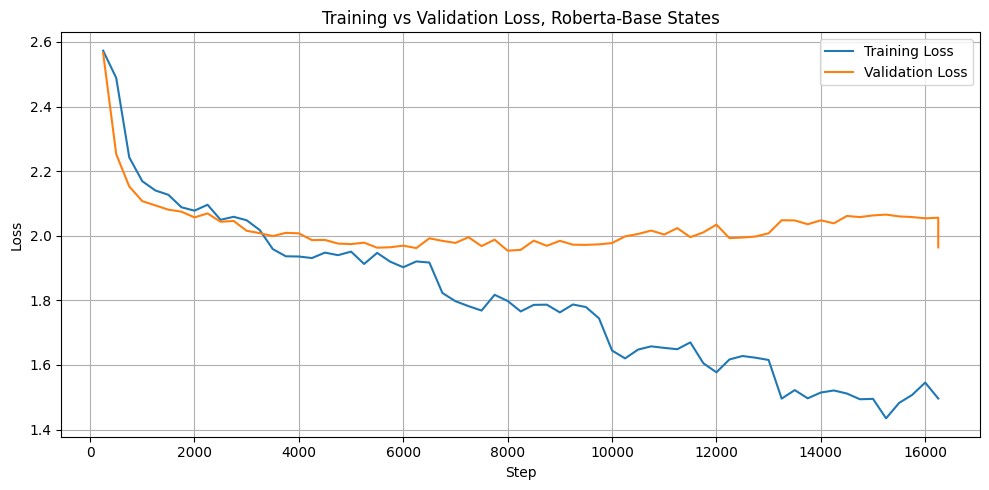

In [21]:
import matplotlib.pyplot as plt

# Get log history
logs = trainer.state.log_history

# Extract training and validation loss values
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
train_steps = [log["step"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss, Roberta-Base States")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
The validation curve shows model stopped improving around 4000 steps. 